<a href="https://colab.research.google.com/github/Lavie-amour/hello/blob/master/LocalAttributionMapsDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting Super-Resolution Networks with Local Attribution Maps

#### Jinjin Gu, Chao Dong

#### Project Page: https://x-lowlevel-vision.github.io/lam.html

This is an online Demo. Please follow the code and comments, step by step

First, click `file` and then COPY you own notebook file to make sure your changes are recorded. Please turn on the colab GPU switch.

**Update:**
- 2021.10.10: All the 150 test images used in the paper can be found at https://drive.google.com/file/d/1xpLNv-r26TnUxKYKJAj3bgtPouclQ3IO/view?usp=sharing
- 2021.10.10: The calculation of the Diffusion Index is updated in this Demo. You can find it at the end of this page.

# Import packages

In [2]:
import torch, cv2, os, sys, numpy as np, matplotlib.pyplot as plt
from PIL import Image

# Load model codes and model files
**This may take a while**

In [3]:
!git clone https://github.com/X-Lowlevel-Vision/LAM_Demo.git
sys.path.append('/content/LAM_Demo')
from ModelZoo.utils import load_as_tensor, Tensor2PIL, PIL2Tensor, _add_batch_one
from ModelZoo import get_model, load_model, print_network
from SaliencyModel.utils import vis_saliency, vis_saliency_kde, click_select_position, grad_abs_norm, grad_norm, prepare_images, make_pil_grid, blend_input
from SaliencyModel.utils import cv2_to_pil, pil_to_cv2, gini
from SaliencyModel.attributes import attr_grad
from SaliencyModel.BackProp import I_gradient, attribution_objective, Path_gradient
from SaliencyModel.BackProp import saliency_map_PG as saliency_map
from SaliencyModel.BackProp import GaussianBlurPath
from SaliencyModel.utils import grad_norm, IG_baseline, interpolation, isotropic_gaussian_kernel

fatal: destination path 'LAM_Demo' already exists and is not an empty directory.


# Load SR Network

In this demo, the avaiable SR networks include:
- 'CARN@Base'    : CARN 
- 'RCAN@Base'    : RCAN 
- 'RRDBNet@Base' : ESRGAN
- 'RNAN@Base'    : RNAN
- 'SAN@Base'     : SAN



In [4]:
model = load_model('RNAN@Base')  # You can Change the model name to load different models

Getting SR Network RNAN
Network [RNAN] was created. Total number of parameters: 9255.0 kelo. To see the architecture, do print(network).
Loading model /content/LAM_Demo/ModelZoo/models/RNAN_SR_F64G10P48BIX4.pt for RNAN network.


# Load test image
We provide 6 images for testing demo

![1](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/1.png?raw=true)
![2](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/2.png?raw=true)
![3](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/3.png?raw=true)
![4](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/4.png?raw=true)
![5](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/5.png?raw=true)
![7](https://github.com/X-Lowlevel-Vision/LAM_Demo/blob/main/test_images/7.png?raw=true)

Their name is :　`1.png`, `2.png`, `3.png`, `4.png`, `5.png`, `7.png`

In [5]:
window_size = 16  # Define windoes_size of D
img_lr, img_hr = prepare_images('LAM_Demo/test_images/7.png')  # Change this image name
tensor_lr = PIL2Tensor(img_lr)[:3] ; tensor_hr = PIL2Tensor(img_hr)[:3]
cv2_lr = np.moveaxis(tensor_lr.numpy(), 0, 2) ; cv2_hr = np.moveaxis(tensor_hr.numpy(), 0, 2)

### Google Colab Does not supper X windows. So input the coordinates manually.

The `plt.imshow` provides you a reference for coordinates.

Please **Estimate** your coordinates

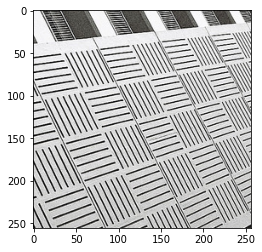

In [6]:
plt.imshow(cv2_hr)

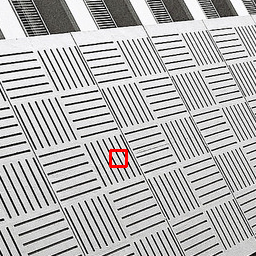

In [7]:
w = 110  # The x coordinate of your select patch, 125 as an example
h = 150  # The y coordinate of your select patch, 160 as an example
         # And check the red box
         # Is your selected patch this one? If not, adjust the `w` and `h`.


draw_img = pil_to_cv2(img_hr)
cv2.rectangle(draw_img, (w, h), (w + window_size, h + window_size), (0, 0, 255), 2)
position_pil = cv2_to_pil(draw_img)
position_pil 

# Calculate the Local Attribution Maps

This also may take a while

In [ ]:
sigma = 1.2 ; fold = 50 ; l = 9 ; alpha = 0.5
attr_objective = attribution_objective(attr_grad, h, w, window=window_size)
gaus_blur_path_func = GaussianBlurPath(sigma, fold, l)
interpolated_grad_numpy, result_numpy, interpolated_numpy = Path_gradient(tensor_lr.numpy(), model, attr_objective, gaus_blur_path_func, cuda=True)
grad_numpy, result = saliency_map(interpolated_grad_numpy, result_numpy)
abs_normed_grad_numpy = grad_abs_norm(grad_numpy)
saliency_image_abs = vis_saliency(abs_normed_grad_numpy, zoomin=4)
saliency_image_kde = vis_saliency_kde(abs_normed_grad_numpy)
blend_abs_and_input = cv2_to_pil(pil_to_cv2(saliency_image_abs) * (1.0 - alpha) + pil_to_cv2(img_lr.resize(img_hr.size)) * alpha)
blend_kde_and_input = cv2_to_pil(pil_to_cv2(saliency_image_kde) * (1.0 - alpha) + pil_to_cv2(img_lr.resize(img_hr.size)) * alpha)
pil = make_pil_grid(
    [position_pil,
     saliency_image_abs,
     blend_abs_and_input,
     blend_kde_and_input,
     Tensor2PIL(torch.clamp(result, min=0., max=1.))]
)

# Analyze the results
From left to right, the images are:
1. The original image with the selected region
2. The LAM result
3. The LAM result with the input image
4. The informative area with the input image
5. The super-resolved image

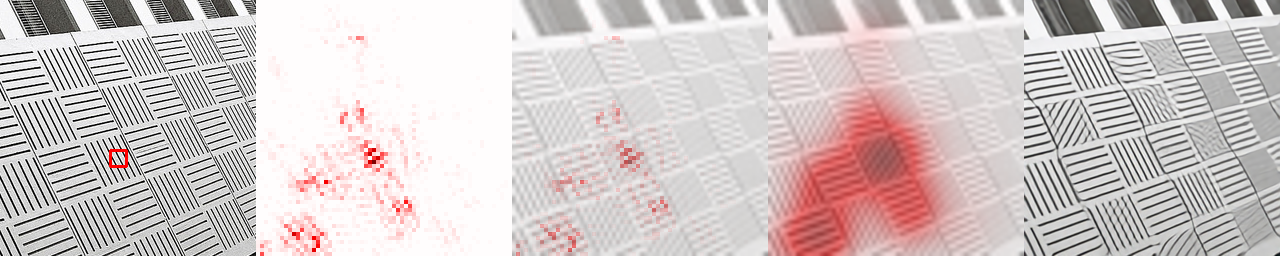

In [ ]:
pil

# Calculate the Diffusion Index

The test set used for quantitative evaluation can be downloaded here: https://drive.google.com/file/d/1xpLNv-r26TnUxKYKJAj3bgtPouclQ3IO/view?usp=sharing

In [ ]:
gini_index = gini(abs_normed_grad_numpy)
diffusion_index = (1 - gini_index) * 100
print(f"The DI of this case is {diffusion_index}")

The DI of this case is 18.729429269483344
